## Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, auc,\
    f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

import optuna
from tqdm import tqdm_notebook
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

RAND = 42
FOLDS = 5

## Load data

In [3]:
df_train = pd.read_csv('data/train.csv', sep = ',', index_col=[0])
df_test = pd.read_csv('data/test.csv', sep = ',')

In [4]:
df_train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [6]:
df_train.shape

(165034, 13)

## EDA

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


In [10]:
df_train.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [14]:
df_train.Exited.value_counts()

0    130113
1     34921
Name: Exited, dtype: int64

In [8]:
df_train.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [9]:
df_train.describe(include=['object'])

,Surname,Geography,Gender
count,165034,165034,165034
unique,2797,3,2
top,Hsia,France,Male
freq,2456,94215,93150


In [5]:
# Удаление столбцов, значение которых уникальны для каждого клиента

df_train.drop(columns = ['CustomerId', 'Surname'], inplace=True)

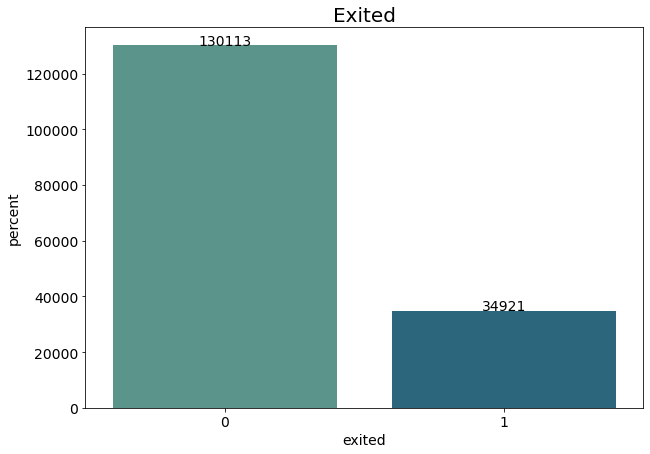

In [59]:
plt.figure(figsize=(10, 7))

ax=sns.countplot(x = df_train['Exited'],
               palette = "crest" )
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, 
            p.get_height() + 2,
            p.get_height() , 
            horizontalalignment='center', 
            fontsize = 14)
plt.title('Остались - покинули');


plt.title('Exited', fontsize=20)
plt.xlabel('exited', fontsize=14)
plt.ylabel('percent', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

- В таргете явно выражен дисбаланс классов

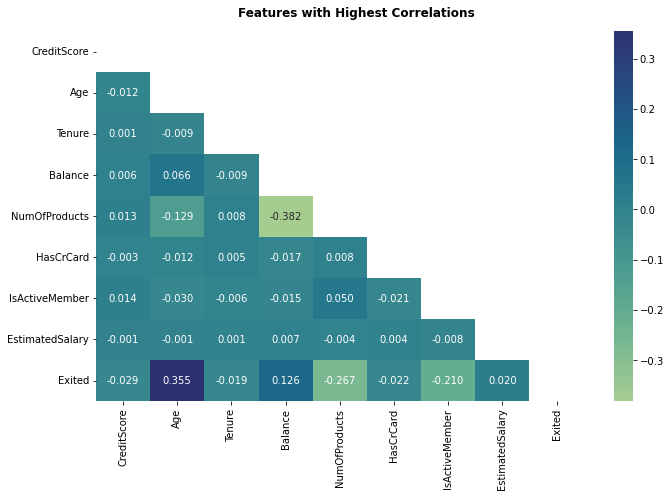

In [12]:
mask = np.triu(df_train.corr())

plt.figure(figsize=(10, 7))
sns.heatmap(df_train.corr(method='spearman'),
            mask=mask,
            annot=True,
            fmt='.3f',
            cmap='crest',
            linewidths=0.00,
            cbar=True)


plt.title('Features with Highest Correlations', weight='bold');

* Сильнее всего таргет кореллирует с признакми Age и Balance
* Особо выделяется связь признаков Balance и NumOfProducts
* Признаки IsActiveMember и NumOfProducts показывают наименьшие значения корреляции с таргетом

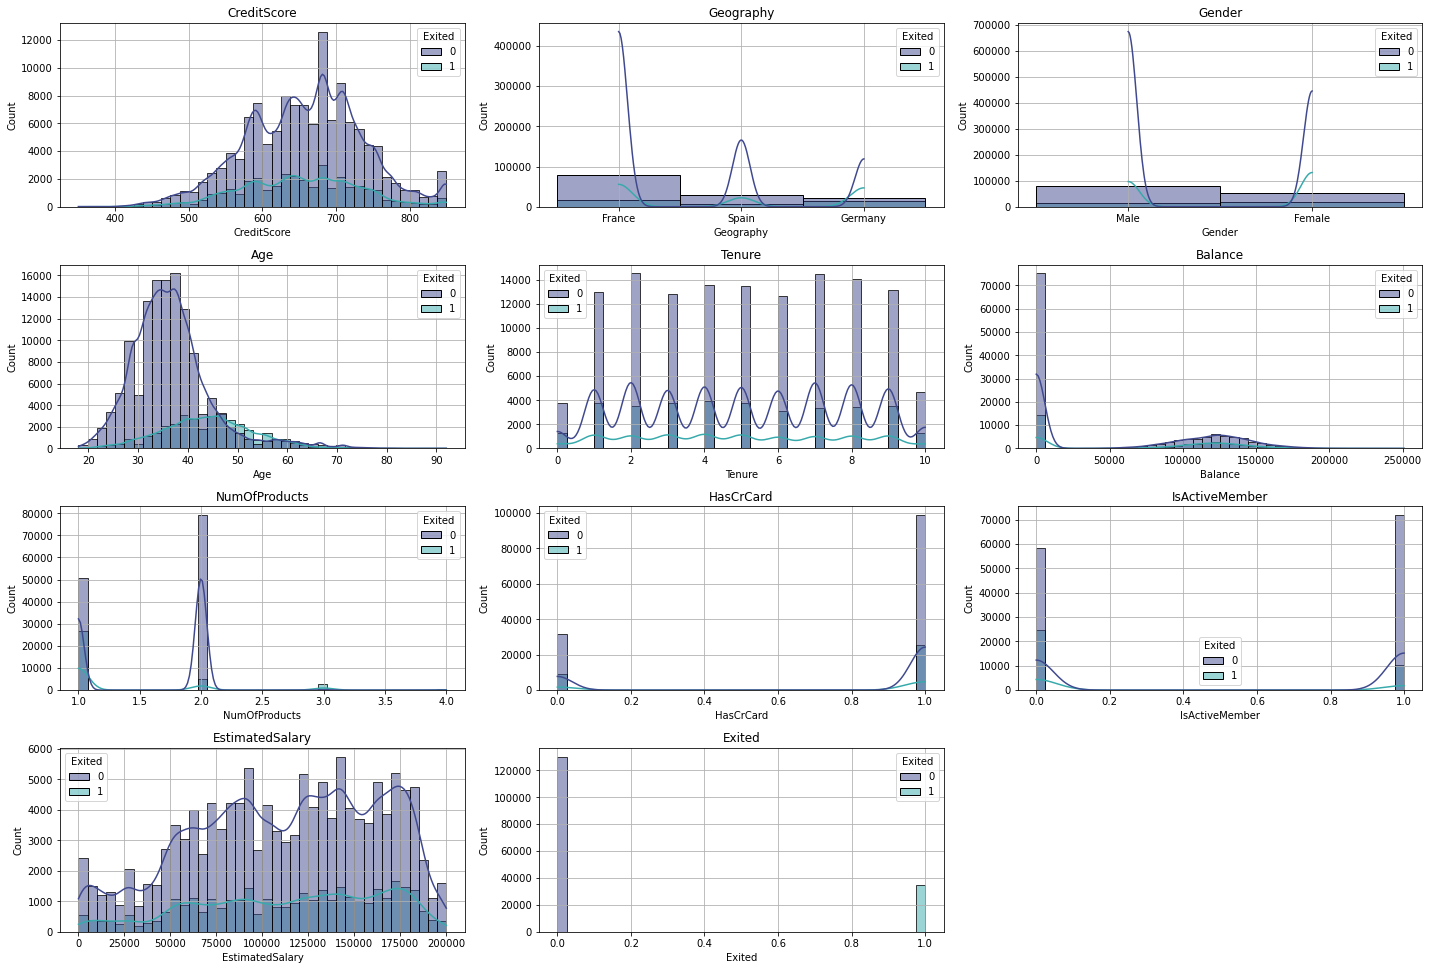

In [12]:
cols = df_train.columns

fig, axes = plt.subplots(figsize=(20, 40))

for i in range(len(cols)):
    plt.subplot(12, 3, i + 1)
    sns.histplot(df_train,
                 x=cols[i],
                 hue="Exited",
                 bins=40,
                 kde=True,
                 palette="mako")
    plt.gca().set_title(cols[i])
    plt.grid(True)

fig.tight_layout()
plt.show()

- При высоком кредитном рейтинге клиенты меньше покидают банк.
- Уходят в основном люди постарше, в особенности те, кому 40-50 лет. 
- Самый маленький шанс оттока у клиентов с 2-мя продуками банка. Но с 3-мя и 4-мя продуктами шансы высокие.
- Шанс потери активного клиента меньше, чем неактивного.

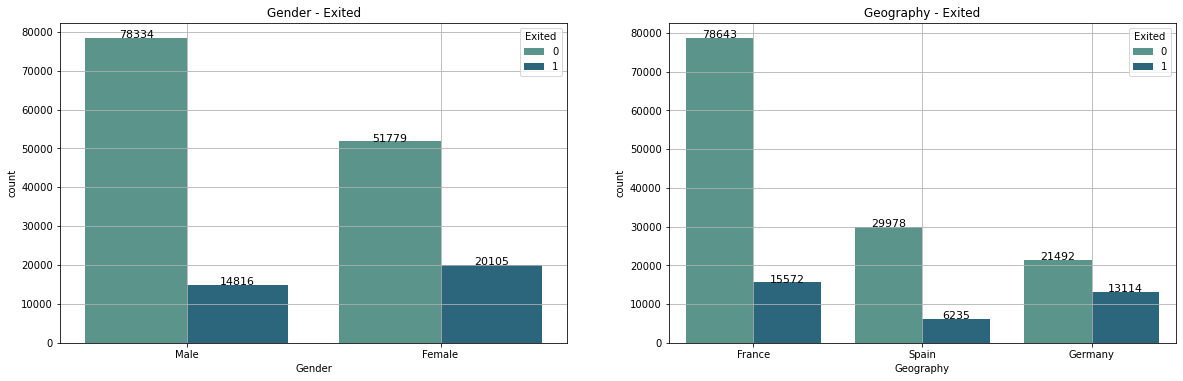

In [25]:
cat_col = ['Gender', 'Geography']
fig = plt.subplots(figsize = (20, 20))
for i in range(len(cat_col)):
    plt.subplot(3,2,i+1)
    ax = sns.countplot(x = cat_col[i],data = df_train,hue = "Exited",palette = "crest")
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 2, p.get_height(),\
                horizontalalignment='center', fontsize = 11)
    title = cat_col[i] + ' - Exited'
    plt.title(title)
    plt.grid(True);

- Germany показвает наибольший отток клиентов, в то время как другие две страны имеют одинаковый уровень распределения классов
- Среди женщин отток на 15% больше

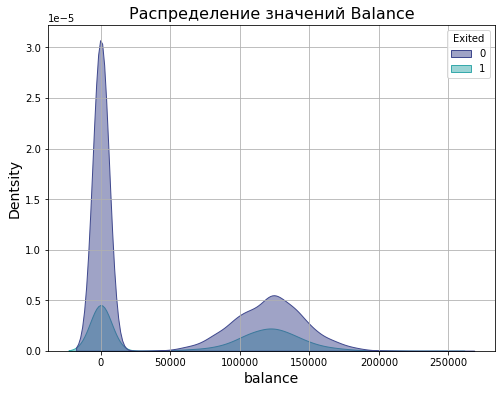

In [19]:
fig = plt.subplots(figsize = (8, 6))
sns.kdeplot(data = df_train,
                x = 'Balance',
                fill = True,
                alpha = 0.5,
                hue = 'Exited',
                palette = "mako")

plt.title('Распределение значений Balance', fontsize=16)
plt.xlabel('balance', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)
plt.grid(True);

- При нулевом балансе шанс оттока ниже, чем в остальных случаях

## Modeling

In [13]:
# кодирую категор-ые признаки
df_dummies = pd.get_dummies(df_train, dtype=int)
df_dummies.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
id,,,,,,,,,,,,,,
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,1,0,0,0,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,1,0,0,0,1
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,1,0,0,0,1
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1,0,0,0,1
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,1,0,1


In [14]:
X = df_dummies.drop(["Exited"], axis=1)
y = df_dummies["Exited"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                     y,
                                                     test_size=0.2,
                                                     stratify=y,
                                                     random_state=42)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    stratify=y_train,
                                                    random_state=42)

In [15]:
def get_metrics(y_test, y_pred, y_score, name):
    df_metrics = pd.DataFrame()
    
    df_metrics['model'] = [name]
    
    df_metrics['roc_auc'] = [roc_auc_score(y_test, y_score[:,1])]
    df_metrics['precision'] = [precision_score(y_test, y_pred)]
    df_metrics['recall'] = [recall_score(y_test, y_pred)]
    df_metrics['f1'] = [f1_score(y_test, y_pred)]
    
    return df_metrics

### LightGBM

#### Basline

In [16]:
lgb = LGBMClassifier(random_state=RAND, is_unbalance=True)

eval_set = [(X_val, y_val)]

lgb.fit(X_train_,
        y_train_,
        eval_metric="auc",
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

LGBMClassifier(is_unbalance=True, random_state=42)

In [17]:
y_pred = lgb.predict(X_test)
y_score = lgb.predict_proba(X_test)

metrics =get_metrics(y_test, y_pred, y_score, 'LGBM')
metrics

,model,roc_auc,precision,recall,f1
0,LGBM,0.889666,0.546144,0.793958,0.647138


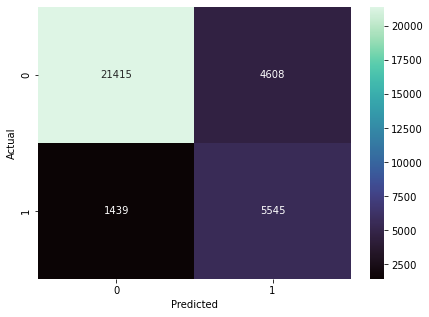

In [18]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="mako", fmt="d", annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual');

#### Optuna

In [19]:
def objective_lgb(trial, X, y, folds, rand):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 500, 1000, step=10), #500
        "max_depth": trial.suggest_categorical("max_depth", [5,10,20]),
        "max_bin": trial.suggest_int("max_bin", 50, 200, step=10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 700, 1000, step=100), #1000
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 10),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 10),
        "min_gain_to_split": trial.suggest_int("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 0.8),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        #"feature_fraction": trial.suggest_float("feature_fraction", 0.5, 0.99),
        "random_state": trial.suggest_categorical("random_state", [rand]),
        "objective": trial.suggest_categorical("objective", ["binary"]),
        "is_unbalance": trial.suggest_categorical("is_unbalance", [True])
    }
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rand)

    cv_predicts = np.empty(folds)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        #pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
        
        model = LGBMClassifier(**lgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="auc",
                  early_stopping_rounds=100,
                  #callbacks=[pruning_callback],
                  verbose=0)

        preds = model.predict_proba(X_test)[:, 1]
        cv_predicts[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_predicts)

In [20]:
study_lgb = optuna.create_study(direction="maximize", study_name="LGB_01")
func = lambda trial: objective_lgb(trial, X_train, y_train, FOLDS, RAND)
study_lgb.optimize(func, n_trials=40, show_progress_bar=True)

[I 2024-04-03 15:34:08,613] A new study created in memory with name: LGB_01


  0%|          | 0/40 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_da

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[I 2024-04-03 15:34:56,811] Trial 9 finished with value: 0.8846554738343115 and parameters: {'n_estimators

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[I 2024-04-03 15:35:11,584] Trial 12 finished with value: 0.8865769227350455 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1307819080493252, 'num_leaves': 830, 'max_depth': 50, 'max_bin': 50, 'min_data_in_leaf': 700, 'lambda_l1': 1, 'lambda_l2': 0, 'min_gain_to_split': 4, 'random_state': 42, 'objective': 'binary', 'is_unbalance': True}. Best is trial 12 with value: 0.8865769227350455.
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_

[I 2024-04-03 15:35:27,092] Trial 15 finished with value: 0.8861597937785699 and parameters: {'n_estimators': 1000, 'learning_rate': 0.13871670888001503, 'num_leaves': 680, 'max_depth': 50, 'max_bin': 50, 'min_data_in_leaf': 700, 'lambda_l1': 6, 'lambda_l2': 0, 'min_gain_to_split': 3, 'random_state': 42, 'objective': 'binary', 'is_unbalance': True}. Best is trial 12 with value: 0.8865769227350455.
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=8, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=8, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[I 2024-04-03 15:36:39,504] Trial 25 finished with value: 0.8860941336293127 and parameters: {'n_estimators': 1000

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[I 2024-04-03 15:37:03,057] Trial 28 finished with value: 0.886314466279749 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03573454158719151, 'num_leaves': 820, 'max_depth': 30, 'max_bin': 70, 'min_data_in_leaf': 900, 'lambda_l1': 1, 'lambda_l2': 2, 'min_gain_to_split': 1, 'random_state': 42, 'objective': 'binary', 'is_unbalance': True}. Best is trial 22 with value: 0.8865915086224904.
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_

[I 2024-04-03 15:37:32,060] Trial 31 finished with value: 0.8865529061392099 and parameters: {'n_estimators': 1000, 'learning_rate': 0.017755272766887202, 'num_leaves': 890, 'max_depth': 50, 'max_bin': 70, 'min_data_in_leaf': 700, 'lambda_l1': 2, 'lambda_l2': 1, 'min_gain_to_split': 0, 'random_state': 42, 'objective': 'binary', 'is_unbalance': True}. Best is trial 22 with value: 0.8865915086224904.
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_t

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in

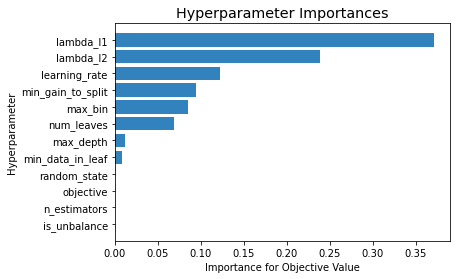

In [34]:
plot_param_importances(study_lgb);

In [35]:
print(f"\tBest value (auc): {study_lgb.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_lgb.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (auc): 0.88650
	Best params:
		n_estimators: 1000
		learning_rate: 0.04475932273347084
		num_leaves: 690
		max_depth: 20
		max_bin: 90
		min_data_in_leaf: 800
		lambda_l1: 0
		lambda_l2: 5
		min_gain_to_split: 4
		random_state: 42
		objective: binary
		is_unbalance: True


In [36]:
study_lgb.best_params

{'n_estimators': 1000,
 'learning_rate': 0.04475932273347084,
 'num_leaves': 690,
 'max_depth': 20,
 'max_bin': 90,
 'min_data_in_leaf': 800,
 'lambda_l1': 0,
 'lambda_l2': 5,
 'min_gain_to_split': 4,
 'random_state': 42,
 'objective': 'binary',
 'is_unbalance': True}

In [21]:
# параметры модели LGBM с лучшими результатами
best_params_lgb = {
    "n_estimators": 1000,
    "learning_rate": 0.012577640454177322,
    "num_leaves": 550,
    "max_depth": 10,
    "max_bin": 140,
    "min_data_in_leaf": 900,
    "lambda_l1": 4,
    "lambda_l2": 5,
    "min_gain_to_split": 3,
    "random_state": 42,
    "objective": "binary",
    "is_unbalance": True
}

In [23]:
lgb_opt = LGBMClassifier(**best_params_lgb)
lgb_opt.fit(X_train_,
             y_train_, 
             eval_metric="auc", 
             eval_set=[(X_val, y_val)],
             early_stopping_rounds=100, 
             verbose=False)

y_pred = lgb_opt.predict(X_test)
y_score = lgb_opt.predict_proba(X_test)

metrics = metrics.append(get_metrics(y_test,
                                     y_pred,
                                     y_score,
                                     name='LGBM_Optuna'
                                     ))
metrics

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


,model,roc_auc,precision,recall,f1
0,LGBM,0.889666,0.546144,0.793958,0.647138
0,LGBoost_Optuna,0.886430,0.619922,0.705756,0.660060
0,LGBM_Optuna,0.886430,0.619922,0.705756,0.660060


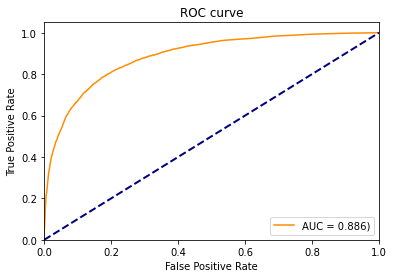

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

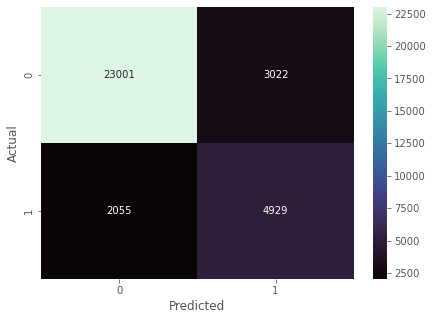

In [41]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred), fmt="d", cmap="mako", annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual');

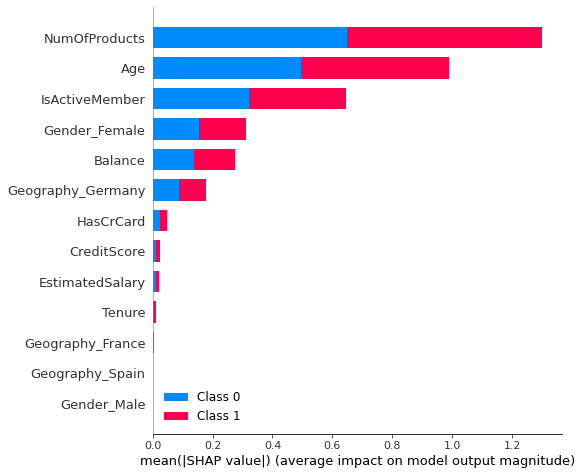

In [13]:
# Важность признаков
explainer = shap.TreeExplainer(lgb_grid)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

### Catboost

#### Baseline

In [43]:
cb = CatBoostClassifier(eval_metric="AUC",
                        random_state=RAND,
                        auto_class_weights="Balanced")

cb.fit(X_train_,
       y_train_,
       eval_set=[(X_val, y_val)],
       early_stopping_rounds=100,
       verbose=False)

y_pred = cb.predict(X_test)
y_score = cb.predict_proba(X_test)

metrics = metrics.append(get_metrics(y_test, y_pred, y_score, "CatBoost"))
metrics

,model,roc_auc,precision,recall,f1
0,LGBM,0.889666,0.546144,0.793958,0.647138
0,LGBoost_Optuna,0.886430,0.619922,0.705756,0.660060
0,CatBoost,0.889818,0.542561,0.795819,0.645229


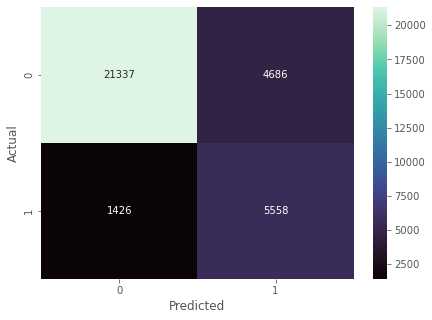

In [44]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred), fmt="d", cmap="mako", annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual');

#### Optuna

In [76]:
def objective_cb(trial, X, y, folds, rand):
    params = {
        "iterations": trial.suggest_categorical("iterations", [2000]),
        #"learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3), #0.07
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["Balanced"]),
        #"max_leaves": trial.suggest_int("max_leaves", 500, 1000, step=10),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 1000, step=100),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0, 10),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS", "No"]),
        #'random_strength': trial.suggest_uniform('random_strength',10,50),
        'grow_policy': trial.suggest_categorical('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]),
        "use_best_model": trial.suggest_categorical("use_best_model", [True]),
        "random_seed": trial.suggest_categorical("random_seed", [rand]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["AUC"])
    }

       
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rand)

    cv_predicts = np.empty(folds)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        #train_data = Pool(data=X_train, label=y_train)
        #eval_data = Pool(data=X_test, label=y_test)
        
        model = CatBoostClassifier(**params)
        model.fit(X_train, 
                  y_train,
                  eval_set=[(X_test, y_test)],
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict_proba(X_test)[:, 1]
        cv_predicts[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_predicts)

In [47]:
study_cb = optuna.create_study(direction="maximize", study_name="CB_01")
func = lambda trial: objective_cb(trial, X_train, y_train, FOLDS, RAND)
study_cb.optimize(func, n_trials=10, show_progress_bar=True)

[I 2024-03-23 18:38:56,366] A new study created in memory with name: CB_01


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-03-23 18:41:06,834] Trial 0 finished with value: 0.8893830534717198 and parameters: {'iterations': 2000, 'auto_class_weights': 'Balanced', 'l2_leaf_reg': 9, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Lossguide', 'use_best_model': True, 'random_seed': 42, 'eval_metric': 'AUC'}. Best is trial 0 with value: 0.8893830534717198.
[I 2024-03-23 18:43:11,685] Trial 1 finished with value: 0.8893205647340853 and parameters: {'iterations': 2000, 'auto_class_weights': 'Balanced', 'l2_leaf_reg': 6, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Depthwise', 'use_best_model': True, 'random_seed': 42, 'eval_metric': 'AUC'}. Best is trial 0 with value: 0.8893830534717198.
[I 2024-03-23 18:44:44,270] Trial 2 finished with value: 0.889125246091085 and parameters: {'iterations': 2000, 'auto_class_weights': 'Balanced', 'l2_leaf_reg': 2, 'bootstrap_type': 'No', 'grow_policy': 'Depthwise', 'use_best_model': True, 'random_seed': 42, 'eval_metric': 'AUC'}. Best is trial 0 with value: 0.8893830534717

In [48]:
print(f"\tBest value (auc): {study_cb.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_cb.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (auc): 0.88938
	Best params:
		iterations: 2000
		auto_class_weights: Balanced
		l2_leaf_reg: 9
		bootstrap_type: Bernoulli
		grow_policy: Lossguide
		use_best_model: True
		random_seed: 42
		eval_metric: AUC


In [55]:
# параметры модели СatBoost с лучшими результатами
best_params_cb = {
    'iterations': 2000,
    'auto_class_weights': 'Balanced',
    'l2_leaf_reg': 9,
    'bootstrap_type': 'Bayesian',
    'grow_policy': 'Lossguide',
    #'use_best_model': True,
    'random_seed': 42,
    'eval_metric': 'AUC'
}

In [57]:
cat_opt = CatBoostClassifier(**best_params_cb)
cat_opt.fit(X_train_,
               y_train_,
               eval_set=[(X_val, y_val)],
               verbose=False,
               early_stopping_rounds=100)

y_pred = cat_opt.predict(X_test)
y_score = cat_opt.predict_proba(X_test)

metrics = metrics.append(
    get_metrics(y_test=y_test,
                y_pred=y_pred,
                y_score=y_score,
                name='CatBoost_Optuna'))

metrics

,model,roc_auc,precision,recall,f1
0,LGBM,0.889666,0.546144,0.793958,0.647138
0,LGBoost_Optuna,0.886430,0.619922,0.705756,0.660060
0,CatBoost,0.889818,0.542561,0.795819,0.645229
0,CatBoost_Optuna,0.889934,0.545794,0.794387,0.647035


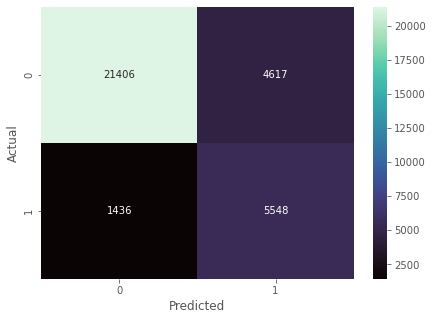

In [58]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred), fmt="d", cmap="mako", annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual');

### XGBoost

In [59]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = XGBClassifier(random_state=RAND, scale_pos_weight=ratio)

xgb.fit(
    X_train_,
    y_train_,
    eval_metric="auc",
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=100,
    verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [60]:
y_pred = xgb.predict(X_test)
y_score = xgb.predict_proba(X_test)

metrics = metrics.append(
    get_metrics(y_test, y_pred, y_score, name='XGB'))
metrics

,model,roc_auc,precision,recall,f1
0,LGBM,0.889666,0.546144,0.793958,0.647138
0,LGBoost_Optuna,0.886430,0.619922,0.705756,0.660060
0,CatBoost,0.889818,0.542561,0.795819,0.645229
0,CatBoost_Optuna,0.889934,0.545794,0.794387,0.647035
0,XGB,0.889107,0.546023,0.787371,0.644855


In [61]:
def objective_xgb(trial, X, y, folds, rand):
    
    xgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        #"max_depth": trial.suggest_categorical("max_depth", [3, 5, 7, 9]),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_int("gamma", 0, 20),
        #"booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "sampling_method": trial.suggest_categorical("sampling_method", ["uniform"]),
        #"colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", [ratio]),
        "random_state": trial.suggest_categorical("random_state", [rand])
    }
    
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rand)

    cv_predicts = np.empty(folds)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-auc")
        
        model = XGBClassifier(**xgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="auc",
                  early_stopping_rounds=100,
                  callbacks=[pruning_callback],
                  verbose=0)
        
        preds = model.predict_proba(X_test)[:, 1]
        cv_predicts[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_predicts)

In [62]:
study_xgb = optuna.create_study(direction="maximize", study_name="XGB_01")
func = lambda trial: objective_xgb(trial, X_train, y_train, FOLDS, RAND)
study_xgb.optimize(func, n_trials=10, show_progress_bar=True)

[I 2024-03-23 19:03:24,393] A new study created in memory with name: XGB_01


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-03-23 19:05:28,860] Trial 0 finished with value: 0.8893963069114144 and parameters: {'n_estimators': 1000, 'learning_rate': 0.046825735807281395, 'min_child_weight': 19, 'gamma': 4, 'subsample': 0.7509394313688972, 'sampling_method': 'uniform', 'scale_pos_weight': 3.7258832372838886, 'random_state': 42}. Best is trial 0 with value: 0.8893963069114144.
[I 2024-03-23 19:11:20,940] Trial 1 finished with value: 0.8878445913143811 and parameters: {'n_estimators': 1000, 'learning_rate': 0.002621349244347619, 'min_child_weight': 9, 'gamma': 5, 'subsample': 0.7981436824490487, 'sampling_method': 'uniform', 'scale_pos_weight': 3.7258832372838886, 'random_state': 42}. Best is trial 0 with value: 0.8893963069114144.
[I 2024-03-23 19:16:58,118] Trial 2 finished with value: 0.8886879536494409 and parameters: {'n_estimators': 1000, 'learning_rate': 0.004328256945837255, 'min_child_weight': 10, 'gamma': 18, 'subsample': 0.508729480877143, 'sampling_method': 'uniform', 'scale_pos_weight': 3.72

In [63]:
print(f"\tBest value (auc): {study_xgb.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (auc): 0.88961
	Best params:
		n_estimators: 1000
		learning_rate: 0.012304701606334744
		min_child_weight: 11
		gamma: 1
		subsample: 0.6485349568853385
		sampling_method: uniform
		scale_pos_weight: 3.7258832372838886
		random_state: 42


In [66]:
# параметры модели XGB с лучшими результатами
best_params_xgb = {
    'n_estimators': 1000,
    'learning_rate': 0.011737740303939407,
    'min_child_weight': 2,
    'gamma': 3,
    'subsample': 0.6478967788112171,
    'sampling_method': 'uniform',
    'scale_pos_weight': 3.7258832372838886,
    'random_state': 42
}

In [68]:
xgb_opt = XGBClassifier(**best_params_xgb)
xgb_opt.fit(X_train_,
             y_train_, 
             eval_metric="auc", 
             eval_set=[(X_val, y_val)], 
             early_stopping_rounds=100, 
             verbose=False)

y_pred = xgb_opt.predict(X_test)
y_score = xgb_opt.predict_proba(X_test)

metrics = metrics.append(get_metrics(y_test,
                                     y_pred,
                                     y_score,
                                     name='XGBoost_Optuna'
                                     ))
metrics

,model,roc_auc,precision,recall,f1
0,LGBM,0.889666,0.546144,0.793958,0.647138
0,LGBoost_Optuna,0.886430,0.619922,0.705756,0.660060
0,CatBoost,0.889818,0.542561,0.795819,0.645229
0,CatBoost_Optuna,0.889934,0.545794,0.794387,0.647035
0,XGB,0.889107,0.546023,0.787371,0.644855
0,XGBoost_Optuna,0.890465,0.552317,0.786798,0.649029


## Submission

In [79]:
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [80]:
test_ids = df_test['id']

df_test.drop(columns = ['CustomerId', 'Surname', 'id'], inplace=True)
test_dummies = pd.get_dummies(df_test, dtype=int)

In [81]:
# использую лучшую модель
y_score_test = lgb_opt.predict_proba(test_dummies)

In [82]:
submission_df = pd.DataFrame({
    'Id': test_ids,
    'class_0': y_score_test[:, 0],
    'class_1': y_score_test[:, 1]
})

In [83]:
submission_df

,Id,class_0,class_1
0,165034,0.903476,0.096524
1,165035,0.273488,0.726512
2,165036,0.880536,0.119464
3,165037,0.527735,0.472265
4,165038,0.431774,0.568226
...,...,...,...
110018,275052,0.826271,0.173729
110019,275053,0.762776,0.237224
110020,275054,0.894792,0.105208
110021,275055,0.644282,0.355718
